### Preliminaries: 

In [74]:
import numpy as np
import pandas as pd 
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix)
import sys

#this will make our arrays print in their entirety instead of truncating
#np.set_printoptions(threshold=sys.maxsize)

In [75]:
#GUIDE: 
    #og_df = original df with all data *don't edit* 
    #df = edited df 
    #sex_df = df sorted by sex (with both prompts) 
    # **gen_df = subset of data with only gender x general prompt **
    # ** ang_df = subset of data with only gender x anger prompt **
    
#This may be way too many dataframes, I'm sorry. The main ones we should be using for now should be the last two 

In [76]:
og_df = pd.read_csv("proj_responses.csv")  #load in dataframe 

In [77]:
df = og_df.copy()   #make copy of df to manipulate 

### Wrangling: 

In [78]:
df = df.drop('Timestamp', axis = 1) #remove timestamp column 
df = df.drop(index = [2, 42]) 

#ignore error msgs 

In [79]:
## binarizing gender column: men = 0, women = 1 
sex_df = df.sort_values("Sex").reset_index()  #sort by gender 
sex_df.loc[0:20, 'Sex'] = 1  #rows 0-20 = 1 for woman
sex_df.loc[21:, 'Sex'] = 0 #rows 21 to end = 0 for man

In [80]:
#making df for general prompt and anger prompt: 
gen_df = sex_df[["Sex", "General Prompt"]]
ang_df = sex_df[["Sex", "Anger Prompt"]]

### Making the Gendered Prompts Columns

In [81]:
## all female gen 
fem_gen = gen_df[0:21]

In [82]:
## all male gen 
men_gen = gen_df[21:]

In [83]:
## all female anger 
fem_anger = ang_df[0:21]

In [84]:
## all male anger 
men_anger = ang_df[21:]

### Making Train/Test

In [85]:
## General Train Set
gen_train = pd.concat([fem_gen[:17], men_gen[:17]])

In [86]:
## General Test Set
gen_test = pd.concat([fem_gen[17:], men_gen[17:]])

In [87]:
## Anger Train Set
ang_train = pd.concat([fem_anger[:17], men_anger[:17]])

In [88]:
## Anger Test Set
ang_test = pd.concat([fem_anger[17:], men_anger[17:]])

## Data Visualizations: 

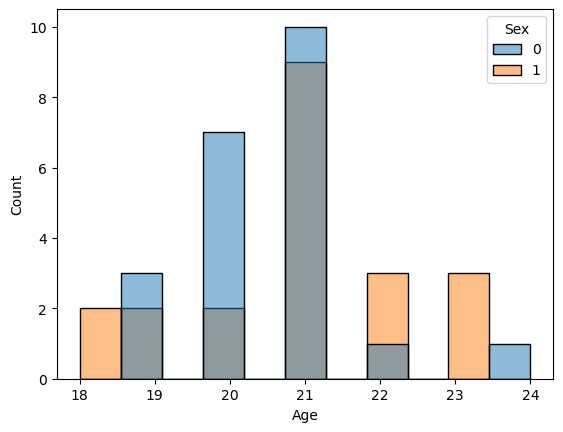

In [89]:
#age hist
sns.histplot(data = sex_df, x = "Age", color = 'pink', hue = 'Sex');

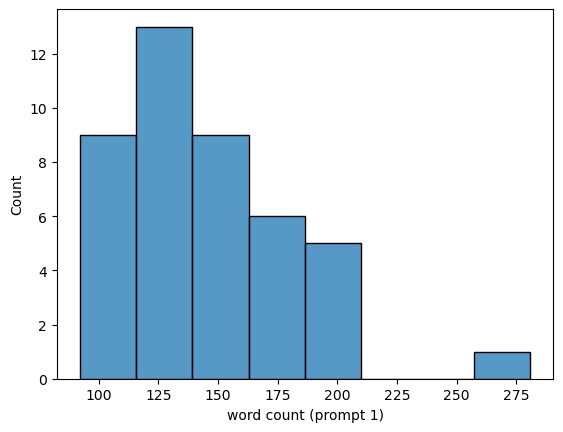

In [90]:
#gen prompt hist
sns.histplot(data= sex_df, x = "word count (prompt 1)");

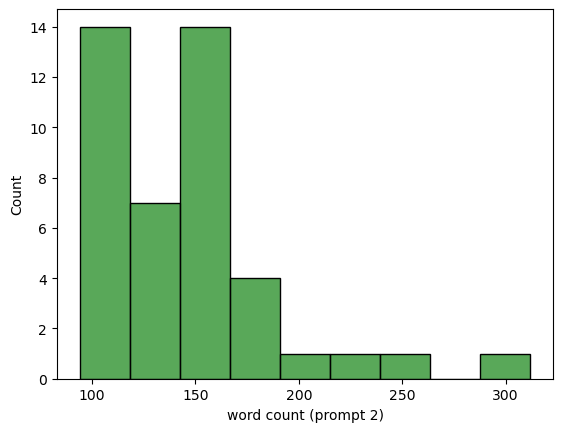

In [91]:
#anger prompt hist
sns.histplot(data= sex_df, x = "word count (prompt 2)", color = 'forestgreen');

### Processing the Text

In [92]:
#import packages
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
ttokenizer = TweetTokenizer() 

In [93]:
#tokenize our general train responses
gen_train_prompts= [] 
for entry in gen_train["General Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    gen_train_prompts.append(tokenized_entry)

In [94]:
#tokenize our general test responeses
gen_test_prompts= [] 
for entry in gen_test["General Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    gen_test_prompts.append(tokenized_entry)

In [95]:
#tokenize our angry train responeses
ang_train_prompts = [] 
for entry in ang_train["Anger Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    ang_train_prompts.append(tokenized_entry)

In [96]:
#tokenize our angry test responeses
ang_test_prompts = [] 
for entry in ang_test["Anger Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    ang_test_prompts.append(tokenized_entry)

### Cleaning entries

In [97]:
#function for removing stop words: 
def remove_stop_words(df): 
    responses_without_stop = []
    
    for entry in df:
        text_with_stop_words = entry
        text_without_stop_words = [word for word in text_with_stop_words if word not in stopwords.words("english")]
        responses_without_stop.append(text_without_stop_words)
    return(responses_without_stop)

In [ ]:
## function for unigram freq: 
def unigram_frequency(list): 
    #create lists to store unigram frequency
    unigram_freqs = []

    #for each entry, calculate n-grams and frequency, then store in respective list 
    for entry in list: 
        unigram_frequency_distribution = nltk.FreqDist(entry)
        unigrams = [ (unigram, unigram_frequency_distribution[unigram]) for unigram in unigram_frequency_distribution ]
        unigram_freqs.append(unigrams)
    return unigram_freqs

In [104]:
# function for unigram vocab: 
def unigram_vocab(freqs_list):
    vocab = [] 

    #for each entry, add every unigram to the unigram vocab
    for entry in freqs_list:
        for x in entry:
            unigram = x[0]
            vocab.append(unigram)
    return vocab

In [120]:
# function to create feature array based on vocab and freq of unigram
def unigram_features(data,vocab):
    features = []
    
    for entry in data: 
        freqs = [0] * len(vocab)
        #for each unigram in tweet, replace frequency in instance list with frequency
        for x in entry:
            unigram = x[0]
            freq = x[1]
            freqs[vocab.index(unigram)] = freq
        #append instance frequency list to features array
        features.append(freqs)
    
    return features

### Unigram Feature: 
- unigram_frequency
- unigram_vocab
- append into master list 
- unigram_features 

In [98]:
## removing stop words from all dfs: 
gen_train_list = remove_stop_words(gen_train_prompts)
gen_test_list = remove_stop_words(gen_test_prompts)
ang_train_list = remove_stop_words(ang_train_prompts)
ang_test_list = remove_stop_words(ang_test_prompts)

In [102]:
#Making frequency list of each individual set
gen_train_freq = unigram_frequency(gen_train_list) 
gen_test_freq = unigram_frequency(gen_test_list) 
ang_train_freq = unigram_frequency(ang_train_list) 
ang_test_freq = unigram_frequency(ang_test_list) 

In [105]:
#Making vocab list of each individual set
gen_train_vocab = unigram_vocab(gen_train_freq) 
gen_test_vocab = unigram_vocab(gen_test_freq) 
ang_train_vocab = unigram_vocab(ang_train_freq) 
ang_test_vocab = unigram_vocab(ang_test_freq) 

In [106]:
#Making master list of each vocab list 
vocabularies = [gen_train_vocab, gen_test_vocab, ang_train_vocab, ang_test_vocab]

# Master list to store all vocabularies
master_list = []

# Loop through each vocabulary and append it to the master_list
for vocab in vocabularies:
    master_list.extend(vocab)

master_list = sorted(list(set(master_list)))

In [121]:
#Making features arrays 
gen_train_feat = unigram_features(gen_train_freq, master_list) 
gen_test_feat = unigram_features(gen_test_freq, master_list) 
ang_train_feat = unigram_features(ang_train_freq, master_list) 
ang_test_feat = unigram_features(ang_test_freq, master_list) 

### Making the Labels: 

In [123]:
gen_train_labels = gen_train['Sex'].tolist()
gen_test_labels = gen_test['Sex'].tolist()
ang_train_labels = ang_train['Sex'].tolist()
ang_test_labels = ang_test['Sex'].tolist()

### Predictive Model based on Unigrams

The confusion matrix displays the following information for us:

|  | **Prediction = 0/Male**   | **Prediction = 1/Female** |
|  ----   | -------- | ------- |
|**Actual = 0/Male** | True Male  | False Female  |
| **Actual = 1/Male**|False Male | True Female    |

We will train a logistic regression model for the general prompt responses and anger prompt responses, then test both models on a respective test set. We will also compute accuracy scores and print a confusion matrix to analyze further. 

In [126]:
#gen model and test

#using L2 regularisation
lm_log_gen = LogisticRegression().fit(gen_train_feat, gen_train_labels)

test_pred = lm_log_gen.predict(gen_test_feat)  
print(test_pred)
test_pred_round = np.round(test_pred)

#print accuracy and confusion matrix
print('Test accuracy: ', accuracy_score(gen_test_labels, test_pred_round))
print ("Confusion Matrix : \n", confusion_matrix(gen_test_labels, test_pred_round) ) 

[1 0 1 1 0 0 0 0 1]
Test accuracy:  0.7777777777777778
Confusion Matrix : 
 [[4 1]
 [1 3]]


In [127]:
#anger model and test
lm_log_ang = LogisticRegression().fit(ang_train_feat, ang_train_labels)

test_pred = lm_log_gen.predict(ang_test_feat)  
print(test_pred)
test_pred_round = np.round(test_pred)

#print accuracy and confusion matrix
print('Test accuracy: ', accuracy_score(ang_test_labels, test_pred_round))
print ("Confusion Matrix : \n", confusion_matrix(ang_test_labels, test_pred_round) ) 

[1 0 0 1 0 1 0 0 1]
Test accuracy:  0.5555555555555556
Confusion Matrix : 
 [[3 2]
 [2 2]]
